In [3]:
import jax
from jax import numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt
from energax.sampling import discrete
from energax import nns, utils
from energax.ebms import nn_ebms

In [4]:
import tensorflow_datasets as tfds
import numpy as np


# adapted from: https://jax.readthedocs.io/en/latest/notebooks/neural_network_with_tfds_data.html
data_dir = "/tmp/tfds"

# Fetch full datasets for evaluation
# tfds.load returns tf.Tensors (or tf.data.Datasets if batch_size != -1)
# You can convert them to NumPy arrays (or iterables of NumPy arrays) with tfds.dataset_as_numpy
mnist_data, info = tfds.load(
    name="mnist", batch_size=-1, data_dir=data_dir, with_info=True
)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data["train"], mnist_data["test"]
num_labels = info.features["label"].num_classes
h, w, c = info.features["image"].shape
num_pixels = h * w * c

# Full train set
train_images, train_labels = train_data["image"], train_data["label"]

train_labels = jnp.array(train_labels).astype("int8")
# Full test set
test_images, test_labels = test_data["image"], test_data["label"]

test_labels = jnp.array(test_labels).astype("int8")

In [5]:
train_images = jnp.array(jnp.reshape(train_images,(train_images.shape[0], 28, 28)))
test_images = jnp.array(jnp.reshape(test_images,(test_images.shape[0], 28, 28)))

In [6]:
key = jax.random.PRNGKey(42)

In [7]:
key, subkey = jax.random.split(key)
ebm = nn_ebms.ContinuousNNEBM(nns.MnistCNN(subkey))

In [8]:
class DiscreteToCont(eqx.Module):
    ebm: eqx.Module
    max_categories: int = 2

    def __call__(self, x):
        if x.shape[-1] != 2:
            x = jax.nn.one_hot(x, self.max_categories, dtype="float32")
        if x.shape[-1] == 2:
            x = utils.softargmax(x, 10.0)
        x = 2 * x - 1.0
        return self.ebm.energy_function(x)

    def energy_function(self, x):
        return self.__call__(x)

In [9]:
gwg_ebm = DiscreteToCont(ebm)

In [10]:
gwg_sampler = discrete.GibbsWithGradient(
    (28, 28), burn_in_steps=50, chain_steps=1, num_chains=4, maxval=2, temp=1e-6
)
gwg_fn = eqx.filter_jit(gwg_sampler.sample_chains)

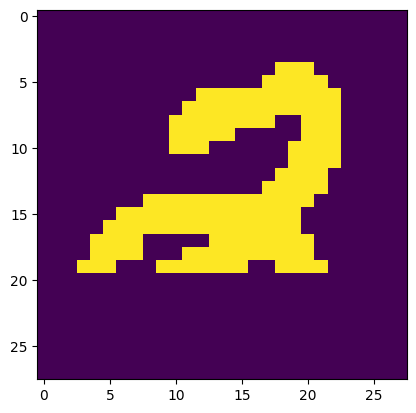

In [11]:
inp_test = (test_images[0] > 0.5).astype("int32").at[-8:, :].set(0)
plt.imshow(inp_test)

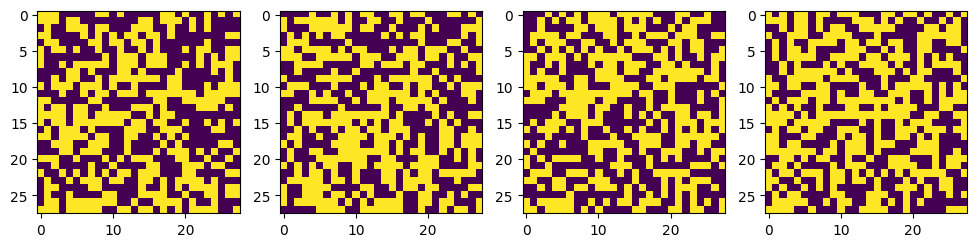

In [12]:
key, subkey = jax.random.split(key, 2)
samples = jnp.squeeze(gwg_fn(gwg_ebm, inp_test, subkey)["position"])

fig, axs = plt.subplots(1, 4, figsize=(12, 3))

for i in range(4):
    axs[i].imshow(samples[i])

plt.show()

In [13]:
gwg_sampler = discrete.GibbsWithGradient(
    (28, 28), burn_in_steps=50, chain_steps=1, num_chains=4, maxval=2, temp=1e-4
)
gwg_fn = eqx.filter_jit(gwg_sampler.sample_chains)

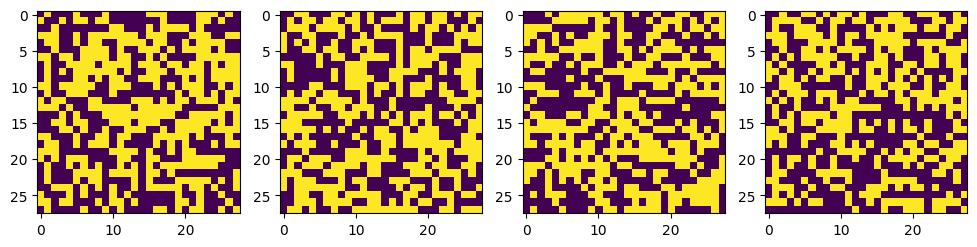

In [18]:
key, subkey = jax.random.split(key, 2)
samples = jnp.squeeze(gwg_fn(gwg_ebm, inp_test, subkey)["position"])

fig, axs = plt.subplots(1, 4, figsize=(12, 3))

for i in range(4):
    axs[i].imshow(samples[i])

plt.show()

In [19]:
class DiscreteToCont(eqx.Module):
    ebm: eqx.Module
    max_categories: int = 255

    def __call__(self, x):
        if x.shape[-1] != self.max_categories:
            x = jax.nn.one_hot(x, self.max_categories, dtype="float32")
        if x.shape[-1] == self.max_categories:
            x = utils.softargmax(x, 10.0)
        x = x / 255.0
        x = 2 * x - 1.0
        return self.ebm.energy_function(x)

    def energy_function(self, x):
        return self.__call__(x)


gwg_ebm = DiscreteToCont(ebm)

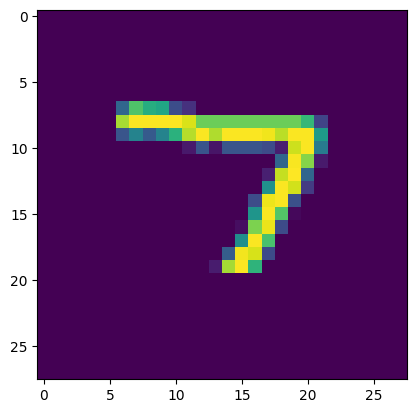

In [20]:
inp_test = (test_images[0] * 255).astype("int32").at[-8:, :].set(0)
plt.imshow(inp_test)

In [21]:
gwg_sampler = discrete.GibbsWithGradient(
    (28, 28), burn_in_steps=50, chain_steps=1, num_chains=4, maxval=255, temp=1e-6
)
gwg_fn = eqx.filter_jit(gwg_sampler.sample_chains)

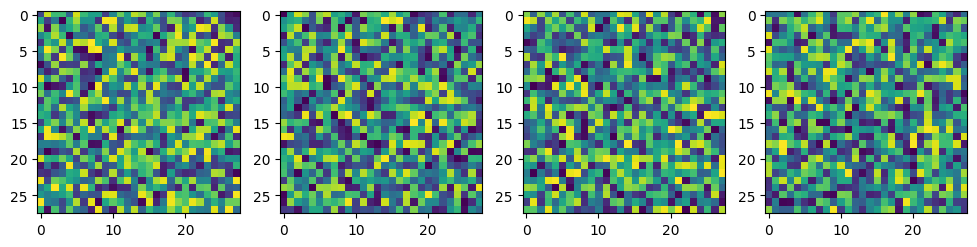

In [22]:
key, subkey = jax.random.split(key, 2)
samples = jnp.squeeze(gwg_fn(gwg_ebm, inp_test, subkey)["position"])

fig, axs = plt.subplots(1, 4, figsize=(12, 3))

for i in range(4):
    axs[i].imshow(samples[i])

plt.show()